# MODFLOW API Paper

## Development of a Custom MODFLOW Package using Python

This notebook can be used to reproduce published results for the "Development of a Custom MODFLOW Package using Python" example, as reported in the MODFLOW 6 API paper (in progress). The MODFLOW 6 API Package is used to add the unknown and known terms for the selected evapotranspiration function to the diagonal of the coefficient matrix and the right-hand side, resepectively.  

## Supported operating systems
This example can be run on the following operating systems:

* linux
* macOS
* Windows

## Prerequisites
To run the simulation and process the results, the following publicly available software and data are required:

* __libmf6.dll__ (Windows) or __libmf6.so__ (linux or MacOS) pre-compiled dynamic-link library (dll)/shared object (so) and available from https://github.com/MODFLOW-USGS/modflow6-nightly-build. The operating specific pre-compiled dll/so should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
* __modflowapi__ is an extension to xmipy. __modflowapi__ including an implementation of its abstract methods. The source is available at https://github.com/MODFLOW-USGS/modflowapi and the module can be installed from PyPI using `pip install modflowapi`. __xmipy__ is an extension to bmipy including an implementation of its abstract methods and the source is available at https://github.com/Deltares/xmipy.
* __flopy__ is a python package that can be used to build, run, and post-process MODFLOW 6 models. The source is available at https://github.com/modflowpy/flopy and the package can be installed from PyPI using `pip install flopy` or conda using `conda install flopy`.

## Running the simulation

We start by importing the necessary packages:

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import flopy
from modflowapi import ModflowApi

In [2]:
sys.path.append(os.path.join("..", "common"))
from figspecs import USGSFigure

### Configure plot settings

In [3]:
fs = USGSFigure(figure_type="graph", 
                family = 'DeJavu Serif') # Por que no tengo "Arial Narrow"

In [4]:

figwidth = 90 # mm
figwidth = figwidth / 10 / 2.54 # inches

In [5]:
color0, color1 = "#440154FF", "#55C667FF"

In [6]:
fig_path = os.path.join("..", "..", "doc", "figures")

### Model name and workspace

In [7]:
name = "etmodel"
ws = os.path.join(".", name)
hds_name = name + ".hds"
cbc_name = name + ".cbc"

print(name)
print(ws)
print(hds_name)
print(cbc_name)

etmodel
.\etmodel
etmodel.hds
etmodel.cbc


In [8]:
if sys.platform == "win32":
    mf6_dll = "libmf6.dll"
elif sys.platform == "darwin":
    mf6_dll = "libmf6.dylib"
else:
    mf6_dll = "libmf6.so"

print(sys.platform, ": ", mf6_dll)

win32 :  libmf6.dll


In [9]:
mf6_dll = os.path.abspath(os.path.join("..", "bin", mf6_dll))
init_ws = os.path.abspath(os.getcwd())
print(mf6_dll, os.path.isfile(mf6_dll), init_ws, sep="\n")

C:\Users\luiggi\Documents\GitSites\MODFLOW_API\emsdatasets\bin\libmf6.dll
True
C:\Users\luiggi\Documents\GitSites\MODFLOW_API\emsdatasets\CustomPackage


### Model parameters

_Spatial and Temporal Discretization_

In [10]:
nlay, nrow, ncol = 10, 1, 1
shape3d = (nlay, nrow, ncol)
shape2d = (nrow, ncol)
delr, delc = 10., 10
area = delr * delc
aquifer_thickness = 5.
dz = aquifer_thickness / nlay
elevations = [0] + np.arange(-dz, -(aquifer_thickness + dz), -dz).tolist()

nper, pertime, nstp, tsmult = 1, 1000., 1000, 1.05

print("Area =",area)
print("Aquifer thickness =", aquifer_thickness)
print("dz =", dz)
print("Elevations =",elevations)

Area = 100.0
Aquifer thickness = 5.0
dz = 0.5
Elevations = [0, -0.5, -1.0, -1.5, -2.0, -2.5, -3.0, -3.5, -4.0, -4.5, -5.0]


_Hydraulic Properties_

In [11]:
k, ss, sy = 1., 1.5e-5, 0.2

_Initial Conditions_

In [12]:
h0 = elevations[0] + 1

print("h0 =", h0)

h0 = 1


_Evapotranspiration Data_

In [13]:
et_surface_depth, et_extinction_depth, et_rate = 0.25, 3., 6e-4

### Build a one-dimensional model

_Simulation Object_

In [14]:
print("name =", name)
print("ws =",ws)

name = etmodel
ws = .\etmodel


In [15]:
sim = flopy.mf6.MFSimulation(
    sim_name=name, 
    sim_ws=ws, 
    verbosity_level=1, 
    memory_print_option="all",
)
flopy.mf6.ModflowTdis(
    sim,
    time_units="days",
    nper=nper,
    perioddata=((pertime, nstp, tsmult),),
)
flopy.mf6.ModflowIms(
    sim, 
    print_option="summary",
    csv_inner_output_filerecord="{}.inner.csv".format(name),
    linear_acceleration="bicgstab", 
    rcloserecord=[1e-6, "strict"],
    inner_dvclose=1e-8,
    outer_dvclose=1e-9,
);

In [16]:
print(sim)

sim_name = etmodel
sim_path = C:\Users\luiggi\Documents\GitSites\MODFLOW_API\emsdatasets\CustomPackage\etmodel
exe_name = mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = etmodel


###################
Package etmodel.tdis
###################

package_name = etmodel.tdis
filename = etmodel.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = etmodel


###################
Package ims_-1
###################

package_name = ims_-1
filename = etmodel.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = etmodel





_Groundwater Flow Model_

In [17]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, newtonoptions="NEWTON UNDER_RELAXATION")
flopy.mf6.ModflowGwfdis(gwf, length_units="meters", nlay=nlay, nrow=nrow, ncol=ncol, 
                        delr=delr, delc=delc, top=elevations[0], botm=elevations[1:])
flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k)
flopy.mf6.ModflowGwfsto(gwf, iconvert=1, ss=ss, sy=sy)
flopy.mf6.ModflowGwfic(gwf, strt=h0)
flopy.mf6.ModflowGwfapi(gwf, 
                        pname="bmi-et", 
                        maxbound=1,
)
flopy.mf6.ModflowGwfoc(gwf, printrecord={0: [("BUDGET", "ALL")]})
obs_lst = []
for k in range(nlay):
    obs_lst.append(["H{:02d}".format(k+1), "HEAD", (k, 0, 0)])
obs = flopy.mf6.ModflowUtlobs(gwf, 
                              print_input=False, 
                              continuous={"head.csv": obs_lst}
                             );

In [18]:
print(gwf)

name = etmodel
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package dis
###################

package_name = dis
filename = etmodel.dis
package_type = dis
model_or_simulation_package = model
model_name = etmodel


###################
Package npf
###################

package_name = npf
filename = etmodel.npf
package_type = npf
model_or_simulation_package = model
model_name = etmodel


###################
Package sto
###################

package_name = sto
filename = etmodel.sto
package_type = sto
model_or_simulation_package = model
model_name = etmodel


###################
Package ic
###################

package_name = ic
filename = etmodel.ic
package_type = ic
model_or_simulation_package = model
model_name = etmodel


###################
Package bmi-et
###################

package_name = bmi-et
filename = etmodel.api
package_type = api
model_or_simulation_package = model
model_name = etmodel


###################
Package oc
###################

package_n

In [19]:
print("obs_lst =", obs_lst)

obs_lst = [['H01', 'HEAD', (0, 0, 0)], ['H02', 'HEAD', (1, 0, 0)], ['H03', 'HEAD', (2, 0, 0)], ['H04', 'HEAD', (3, 0, 0)], ['H05', 'HEAD', (4, 0, 0)], ['H06', 'HEAD', (5, 0, 0)], ['H07', 'HEAD', (6, 0, 0)], ['H08', 'HEAD', (7, 0, 0)], ['H09', 'HEAD', (8, 0, 0)], ['H10', 'HEAD', (9, 0, 0)]]


In [20]:
print("obs =", obs)

obs = package_name = obs_0
filename = etmodel.obs
package_type = obs
model_or_simulation_package = model
model_name = etmodel

Block options
--------------------
print_input
{internal}
(False)


Block continuous
--------------------
continuous
{internal}
([('H01', 'HEAD', (0, 0, 0), None) ('H02', 'HEAD', (1, 0, 0), None)
 ('H03', 'HEAD', (2, 0, 0), None) ('H04', 'HEAD', (3, 0, 0), None)
 ('H05', 'HEAD', (4, 0, 0), None) ('H06', 'HEAD', (5, 0, 0), None)
 ('H07', 'HEAD', (6, 0, 0), None) ('H08', 'HEAD', (7, 0, 0), None)
 ('H09', 'HEAD', (8, 0, 0), None) ('H10', 'HEAD', (9, 0, 0), None)])





_Write the Model Files_

In [21]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model etmodel...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package bmi-et...
    writing package oc...
    writing package obs_0...


_Retrieve a few processed items from the GWF model_

In [22]:
gwf_top = gwf.dis.top.array
gwf_botm = gwf.dis.botm.array
print(gwf_top.shape, gwf_botm.shape)
print(gwf_top, gwf_botm[-1])

(1, 1) (10, 1, 1)
[[0.]] [[-5.]]


In [23]:
print(gwf_botm)

[[[-0.5]]

 [[-1. ]]

 [[-1.5]]

 [[-2. ]]

 [[-2.5]]

 [[-3. ]]

 [[-3.5]]

 [[-4. ]]

 [[-4.5]]

 [[-5. ]]]


### Functions to calculate ET rate

_Exponential_

In [24]:
def et_terms(head, function="constant"):
    top = elevations[0]
    zs = top - et_surface_depth
    ze = top - et_extinction_depth
    if function == "constant":
        hcof, rhs, Q = constant_et(ze, head[0])
    elif function == "linear":
        hcof, rhs, Q = linear_et(zs, ze, head[0])
    elif function == "exponential":
        hcof, rhs, Q = exponential_et(zs, ze, head[0])
    return hcof, rhs, Q

_Constant_

$Q_{ET}$ is not head dependent so $hcof$ is always 0 and $rhs$ is equal to $Q_{max}$ when $h \ge z_e$.

In [25]:
def constant_et(ze, h):
    Qmax = et_rate * area
    hcof = 0.
    if h > ze:
        rhs = Qmax
    else:
        rhs = 0.
    return hcof, rhs, -rhs

_Linear_

- $Q_{ET}$ is not head dependent when $h > z_s$. In this case, $hcof$ is 0 and $rhs$ is equal to $Q_{max}$

- $Q_{ET}$ is head dependent when $z_s \ge h > ze$ and $Q_{ET} = Q_{max} \left(1 -  \frac{z_s - h}{z_s - z_e} \right)$. In this case, $hcof = -Q_{max} / (z_s - z_e)$ and $rhs =Q_{max} - Q_{max} \frac{z_s}{z_s - z_e}$

- $Q_{ET}$ is 0 when $h < z_e$. In this case, $hcof$ is 0 and $rhs$ is equal to 0


In [26]:
def linear_et(zs, ze, h):
    Qmax = et_rate * area
    depth = zs - ze
    if h > zs:
        hcof = 0.
        rhs = Qmax
    elif h > ze:
        hcof = -Qmax / depth
        rhs = Qmax - Qmax * zs / depth
    else:
        hcof = 0.
        rhs = 0.
    return hcof, rhs, hcof * h - rhs

_Exponential_

- $Q_{ET}$ is not head dependent when $h > z_s$. In this case, $hcof$ is 0 and $rhs$ is equal to $Q_{max}$

- $Q_{ET}$ is head dependent when $z_s \ge h > ze$ and $Q_{ET} = Q_{max} e ^{-3\pi \frac{z_s - h}{z_s - z_e}}$. $Q_{ET}$ is linearized using the Newton-Raphson formulation to improve convergence of the non-linear equation. In this case, $hcof = \frac{\partial Q_{max}}{\partial h}$ and $rhs = -Q_{max} + \frac{\partial Q_{max}}{\partial h} h^{k-1}$, where $h^{k-1}$ is the current head.

- $Q_{ET}$ is 0 when $h < z_e$. In this case, $hcof$ is 0 and $rhs$ is equal to 0


In [27]:
def exponential_et(zs, ze, h, exp_factor=3.):
    Qmax = et_rate * area
    depth = zs - ze
    if h > zs:
        Q = -Qmax
        hcof = 0.
        rhs = Qmax
    elif h > ze:
        exp_pow = -exp_factor * np.pi * (zs - h) / depth
        Q = -Qmax * np.e ** exp_pow
        derv = Q * (-exp_factor * np.pi / depth)
        hcof = derv
        rhs = -Q + derv * h
    else:
        Q = 0.
        hcof = 0.
        rhs = 0.
    return hcof, rhs, Q   

### Function to find the node number of the upper most active cell

In [28]:
def get_node(head):
    hc = head.copy().reshape(shape3d)
    sat = hc > gwf_botm
    kbot = nlay - 1
    layer = np.ones(shape2d, dtype=np.int32) * -999
    for k in range(nlay):
        idx = (sat[k]) & (layer < 0)
        layer[idx] = k
    return (layer + 1).flatten()

### Function to run bmi with a specific ET model

In [29]:
def bmi_model(function="constant", verbose=False):
    success = False
    
    # create et observations
    dtype = [("time", np.float64), ("ET", np.float64)]
    earr = np.zeros(nstp, dtype=dtype)

    mf6_config_file = os.path.join(ws, 'mfsim.nam')
    mf6 = ModflowApi(mf6_dll, working_directory=ws)

    # initialize the model
    mf6.initialize(mf6_config_file)

    # time loop
    current_time = mf6.get_current_time()
    end_time = mf6.get_end_time()

    # get pointer to simulated heads
    head_tag = mf6.get_var_address("X", name.upper())
    head = mf6.get_value_ptr(head_tag)
    
    # maximum outer iterations
    max_iter = mf6.get_value(
        mf6.get_var_address("MXITER", "SLN_1")
    )

    # get pointers to API data
    nodelist_address = mf6.get_var_address("NODELIST", name.upper(), "BMI-ET")
    nbound_address = mf6.get_var_address("NBOUND", name.upper(), "BMI-ET")
    nbound = mf6.get_value_ptr(nbound_address)
    hcof_address = mf6.get_var_address("HCOF", name.upper(), "BMI-ET")
    rhs_address = mf6.get_var_address("RHS", name.upper(), "BMI-ET")
    
    nodelist = mf6.get_value(nodelist_address)
    hcof = mf6.get_value(hcof_address)
    rhs = mf6.get_value(rhs_address)
    
    # set nodelist and nbound
    node0 = 0
    nodelist[0] = node0
    nbound[0] = 1

    # model time loop
    idx = 0
    while current_time < end_time:

        # get dt and prepare for non-linear iterations
        dt = mf6.get_time_step()
        mf6.prepare_time_step(dt)

        # convergence loop
        kiter = 0
        mf6.prepare_solve()

        while kiter < max_iter:
            # update the nodelist
            nodelist[:] = get_node(head)
            # update hcof and rhs rate
            hcof[:], rhs[:], Qts = et_terms(
                head, 
                function=function
            )
            # set values
            mf6.set_value(nodelist_address, nodelist)
            mf6.set_value(hcof_address, hcof)
            mf6.set_value(rhs_address, rhs)
            if verbose:
                print(kiter, hcof[0], rhs[0])

            # solve with updated well rate
            has_converged = mf6.solve(1)
            kiter += 1

            if has_converged:
                if nodelist[0] != node0:
                    node0 = nodelist[0]
                    print("ET from layer {}".format(node0))
                if verbose:
                    msg = "Component {}".format(1) + \
                          " converged in {}".format(kiter) + " outer iterations"
                    print(msg)
                break

        # finalize time step
        mf6.finalize_solve()

        # finalize time step and update time
        mf6.finalize_time_step()
        current_time = mf6.get_current_time()

        # terminate if model did not converge
        if not has_converged:
            print("model did not converge")
            break
        
        # add 
        earr["time"][idx] = current_time
        earr["ET"][idx] = Qts

        # increment counter
        idx += 1
    
    # cleanup
    try:
        mf6.finalize()
        success = True
    except:
        raise RuntimeError
    
    # process the observations
    fpth = os.path.join(ws, "head.csv")
    harr = np.genfromtxt(fpth, names=True, delimiter=',')
    fpth = os.path.join(ws, "{}.inner.csv".format(name))
    imsarr = np.genfromtxt(fpth, names=True, delimiter=',')
    
    # return the observation data for this simulation
    return success, harr, earr, imsarr

Run the constant et function

In [30]:
success, h0, et0, ims0 = bmi_model(function="constant", verbose=False)

ET from layer 1
ET from layer 2
ET from layer 3
ET from layer 4
ET from layer 5
ET from layer 6


In [31]:
success, h1, et1, ims1 = bmi_model(function="linear", verbose=False)

ET from layer 1
ET from layer 2
ET from layer 3
ET from layer 4


In [32]:
success, h2, et2, ims2 = bmi_model(function="exponential", verbose=False)

ET from layer 1
ET from layer 2


Total number of inner iterations

In [33]:
ims0["total_inner_iterations"].max(), ims1["total_inner_iterations"].max(), ims2["total_inner_iterations"].max()

(np.float64(2247.0), np.float64(2247.0), np.float64(2737.0))

### Simulated model results

In [34]:
h0.dtype.names

('time', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10')

Calculate the timestep length

In [35]:
dt = np.zeros(h0.shape, dtype=np.float64)
dt[0] = h0["time"][0]
dt[1:] = h0["time"][1:] - h0["time"][0:-1]

Plot the simulated model results

In [36]:
# set values needed for the evapotranspiration functions
surf_elev, surf, extdepth, qmax = elevations[0], et_surface_depth, et_extinction_depth, 1.
head = np.arange(1, elevations[-1], -0.01)

# plot the results
xticks = (0., 0.25, 0.5, 0.75, 1.)
yticks = np.arange(1, -6, -1)

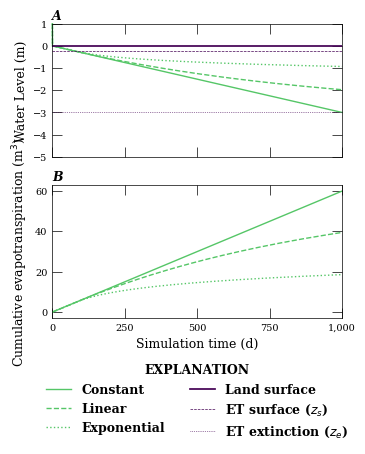

In [37]:
figheight = figwidth * 1.25
box = dict(facecolor="none", edgecolor="none", pad=5, alpha=0.2)
fig = plt.figure(figsize=(figwidth, figheight),
                 constrained_layout=True,)
gs = gridspec.GridSpec(10,1, figure=fig)
ax0 = fig.add_subplot(gs[0:4, :])
ax1 = fig.add_subplot(gs[4:8, :])
ax2 = fig.add_subplot(gs[8:, :])

for ax in (ax0, ax1, ax2):
    ax.set_xlim(0, 1000)
    

ax = ax0
ax.set_ylim(yticks[-1], yticks[0])
ax.set_xticks([0, 250, 500, 750, 1000])
ax.plot(h0["time"], h0["H01"], color=color1, lw=1, label="Constant", clip_on=False)
ax.plot(h1["time"], h1["H01"], color=color1, ls="--", lw=1, label="Linear", clip_on=False)
ax.plot(h2["time"], h2["H01"], color=color1, ls=":", lw=1, label="Exponential", clip_on=False)

# plot et parameters and top of aquifer
ax.axhline(surf_elev, color=color0, lw=1.25, label="Land surface")
ax.axhline(surf_elev-surf, color=color0, lw=0.5, ls="--", label="ET surface")
ax.axhline(surf_elev-extdepth, color=color0, ls=":", lw=0.5, label="ET extinction")

ax.set_ylabel("Water Level (m)", bbox=box)
ax.xaxis.set_ticklabels([])
fs.heading(ax, idx=0)
fs.remove_edge_ticks(ax);

ax = ax1
ax.set_xticks([0, 250, 500, 750, 1000])

ax.plot(h0["time"], -(et0["ET"] * dt).cumsum(), color=color1, lw=1, label="Constant")
ax.plot(h1["time"], -(et1["ET"] * dt).cumsum(), color=color1, ls="--", lw=1, label="Linear")
ax.plot(h2["time"], -(et2["ET"] * dt).cumsum(), color=color1, ls=":", lw=1, label="Exponential")

ax.xaxis.set_tick_params(which='both', labelbottom=True)
ax.xaxis.set_ticklabels(["0", "250", "500", "750", "1,000"])
ax.set_xlabel("Simulation time (d)")
ax.set_ylabel("Cumulative evapotranspiration (m$^3$)", bbox=box)
fs.heading(ax, idx=1)
fs.remove_edge_ticks(ax);

ax = ax2
xy0 = (-100, -100)
ax.set_ylim(0, 1)
ax.set_axis_off()

# fake data to set up legend
ax.plot(xy0, xy0, color=color1, lw=1, label="Constant")
ax.plot(xy0, xy0, color=color1, ls="--", lw=1, label="Linear")
ax.plot(xy0, xy0, color=color1, ls=":", lw=1, label="Exponential")

# plot et parameters and top of aquifer
ax.axhline(xy0[0], color=color0, lw=1.25, label="Land surface")
ax.axhline(xy0[0], color=color0, lw=0.5, ls="--", label="ET surface ($z_s$)")
ax.axhline(xy0[0], color=color0, ls=":", lw=0.5, label="ET extinction ($z_e$)")
fs.graph_legend(ax, ncol=2, loc="center");

if os.path.isdir(fig_path):
    fpth = os.path.join(fig_path, "ex-1-simet.png")
    plt.savefig(fpth, dpi=600);

In [ ]:
(et0["ET"] * dt).cumsum()[-1], (et1["ET"] * dt).cumsum()[-1], (et2["ET"] * dt).cumsum()[-1]

In [ ]:
h0["H01"][-1], h1["H01"][-1], h2["H01"][-1]